<div style="background-color: #04da79; border: 2px solid #039754; padding: 10px; color: black; font-family: Arial, Helvetica, sans-serif;">
    <strong>Kernel: Python 3 (ipykernel)
</div>

# Fine-tuning Qwen2-VL with video/text dataset

This notebook shows how to fine-tune a vision Large Language Model (visionLLM) on a video-text to text dataset. The visionLLM can answer questions and extract information from the videos.

This notebook uses a SageMaker remote function to run the GPU intensive training as a cost efficient SageMaker training job, where you only pay for the actual execution time and resources required by your job.

## Setup

Let's start by importing necessary packages

In [1]:
import os
from pathlib import Path
import pandas as pd
import sagemaker
from IPython.display import JSON, Video
from huggingface_hub import snapshot_download

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Dataset for Fine-Tuning

We first need to setup the dataset that we want to do the finetuning on.

* Download a small sample dataset based on [LLaVA-Video-178K](https://huggingface.co/datasets/lmms-lab/LLaVA-Video-178K) into your `./local_data` folder
* Upload the dataset to S3

In [2]:
role = sagemaker.get_execution_role()
region = sagemaker.session.Session().boto_region_name
session = sagemaker.Session()
default_bucket_name = session.default_bucket()
dataset_dir = "./local_data"
dataset_s3_prefix = "myvideotrainingdataset"
dataset_s3_uri = f"s3://{default_bucket_name}/{dataset_s3_prefix}"

In [3]:
file_path = snapshot_download(
    repo_id="malterei/LLaVA-Video-small-swift",
    repo_type="dataset",
    local_dir=dataset_dir
)
print(f"Downloaded dataset to local filepath: {file_path}")

Fetching 210 files:   0%|          | 0/210 [00:00<?, ?it/s]

test.jsonl:   0%|          | 0.00/4.07k [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/38.2k [00:00<?, ?B/s]

07LG5.mp4:   0%|          | 0.00/2.34M [00:00<?, ?B/s]

(…)illa-qwen2-vl-2b-instruct-response.jsonl:   0%|          | 0.00/5.19k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/2.42k [00:00<?, ?B/s]

validation.jsonl:   0%|          | 0.00/4.67k [00:00<?, ?B/s]

03M0K.mp4:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

11106167914.mp4:   0%|          | 0.00/2.79M [00:00<?, ?B/s]

10576728026.mp4:   0%|          | 0.00/2.44M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/335 [00:00<?, ?B/s]

1YC83.mp4:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

1ECM2.mp4:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

1KKYX.mp4:   0%|          | 0.00/1.61M [00:00<?, ?B/s]

2403134475.mp4:   0%|          | 0.00/2.97M [00:00<?, ?B/s]

2400900222.mp4:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

2632387219.mp4:   0%|          | 0.00/1.73M [00:00<?, ?B/s]

2PREF.mp4:   0%|          | 0.00/1.55M [00:00<?, ?B/s]

2QI8F.mp4:   0%|          | 0.00/1.60M [00:00<?, ?B/s]

3564576864.mp4:   0%|          | 0.00/2.97M [00:00<?, ?B/s]

3643922241.mp4:   0%|          | 0.00/1.76M [00:00<?, ?B/s]

2IX2Z.mp4:   0%|          | 0.00/828k [00:00<?, ?B/s]

4004287747.mp4:   0%|          | 0.00/2.30M [00:00<?, ?B/s]

4255049031.mp4:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

42SEP.mp4:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

4329580374.mp4:   0%|          | 0.00/2.47M [00:00<?, ?B/s]

4931493992.mp4:   0%|          | 0.00/1.09M [00:00<?, ?B/s]

4360431067.mp4:   0%|          | 0.00/994k [00:00<?, ?B/s]

4DZB6.mp4:   0%|          | 0.00/372k [00:00<?, ?B/s]

5235909148.mp4:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

5987365500.mp4:   0%|          | 0.00/2.51M [00:00<?, ?B/s]

6TVXT.mp4:   0%|          | 0.00/2.57M [00:00<?, ?B/s]

7748596700.mp4:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

6LGTT.mp4:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

6913450810.mp4:   0%|          | 0.00/2.07M [00:00<?, ?B/s]

7004267908.mp4:   0%|          | 0.00/2.98M [00:00<?, ?B/s]

9338319433.mp4:   0%|          | 0.00/2.69M [00:00<?, ?B/s]

8Y7P5.mp4:   0%|          | 0.00/2.30M [00:00<?, ?B/s]

9963900426.mp4:   0%|          | 0.00/2.88M [00:00<?, ?B/s]

9CCDY.mp4:   0%|          | 0.00/714k [00:00<?, ?B/s]

AVH53.mp4:   0%|          | 0.00/1.85M [00:00<?, ?B/s]

B2NAS.mp4:   0%|          | 0.00/724k [00:00<?, ?B/s]

ARKBT.mp4:   0%|          | 0.00/989k [00:00<?, ?B/s]

B7SZJ.mp4:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

BIV8M.mp4:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

DFEG2.mp4:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

DVPL2.mp4:   0%|          | 0.00/1.24M [00:00<?, ?B/s]

CX5ZM.mp4:   0%|          | 0.00/759k [00:00<?, ?B/s]

DXVRB.mp4:   0%|          | 0.00/747k [00:00<?, ?B/s]

ES10S.mp4:   0%|          | 0.00/940k [00:00<?, ?B/s]

FYHTC.mp4:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

H4ZD8.mp4:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

HP3HV.mp4:   0%|          | 0.00/944k [00:00<?, ?B/s]

IRBPD.mp4:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

KEPDQ.mp4:   0%|          | 0.00/174k [00:00<?, ?B/s]

KVYOZ.mp4:   0%|          | 0.00/317k [00:00<?, ?B/s]

MLS4T.mp4:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

MZK2X.mp4:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

NSUHV.mp4:   0%|          | 0.00/1.89M [00:00<?, ?B/s]

MME0V.mp4:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

OTIA2.mp4:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

PK2F0.mp4:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

RW587.mp4:   0%|          | 0.00/2.21M [00:00<?, ?B/s]

QBQR3.mp4:   0%|          | 0.00/1.47M [00:00<?, ?B/s]

S6RYI.mp4:   0%|          | 0.00/1.41M [00:00<?, ?B/s]

VIN5T.mp4:   0%|          | 0.00/788k [00:00<?, ?B/s]

T38JM.mp4:   0%|          | 0.00/786k [00:00<?, ?B/s]

WK5PL.mp4:   0%|          | 0.00/632k [00:00<?, ?B/s]

YB67Z.mp4:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

VKDLS.mp4:   0%|          | 0.00/266k [00:00<?, ?B/s]

YKT8I.mp4:   0%|          | 0.00/468k [00:00<?, ?B/s]

13AUQ.mp4:   0%|          | 0.00/1.62M [00:00<?, ?B/s]

8Y7P5.mp4:   0%|          | 0.00/2.30M [00:00<?, ?B/s]

3RN5M.mp4:   0%|          | 0.00/1.18M [00:00<?, ?B/s]

0AGCS.mp4:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

45BIP.mp4:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

5Z1CO.mp4:   0%|          | 0.00/1.90M [00:00<?, ?B/s]

ALXUC.mp4:   0%|          | 0.00/614k [00:00<?, ?B/s]

CX5ZM.mp4:   0%|          | 0.00/759k [00:00<?, ?B/s]

9207X.mp4:   0%|          | 0.00/868k [00:00<?, ?B/s]

DP1TV.mp4:   0%|          | 0.00/448k [00:00<?, ?B/s]

2IX2Z.mp4:   0%|          | 0.00/828k [00:00<?, ?B/s]

13XM4.mp4:   0%|          | 0.00/1.95M [00:00<?, ?B/s]

FY9UT.mp4:   0%|          | 0.00/664k [00:00<?, ?B/s]

GG4UR.mp4:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

F31X6.mp4:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

EJY5V.mp4:   0%|          | 0.00/1.43M [00:00<?, ?B/s]

GX4B1.mp4:   0%|          | 0.00/3.45M [00:00<?, ?B/s]

HQ8K2.mp4:   0%|          | 0.00/1.18M [00:00<?, ?B/s]

IA7X9.mp4:   0%|          | 0.00/1.53M [00:00<?, ?B/s]

IPH08.mp4:   0%|          | 0.00/1.02M [00:00<?, ?B/s]

J53NS.mp4:   0%|          | 0.00/1.17M [00:00<?, ?B/s]

KEPDQ.mp4:   0%|          | 0.00/174k [00:00<?, ?B/s]

JIS2Q.mp4:   0%|          | 0.00/521k [00:00<?, ?B/s]

LRDW5.mp4:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

M79TJ.mp4:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

MLS4T.mp4:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

NYDRK.mp4:   0%|          | 0.00/2.14M [00:00<?, ?B/s]

OADOE.mp4:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

OPPVW.mp4:   0%|          | 0.00/1.69M [00:00<?, ?B/s]

PK2F0.mp4:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

P36YW.mp4:   0%|          | 0.00/1.50M [00:00<?, ?B/s]

P23HN.mp4:   0%|          | 0.00/2.08M [00:00<?, ?B/s]

RIE30.mp4:   0%|          | 0.00/465k [00:00<?, ?B/s]

RTEO8.mp4:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

RVV5Q.mp4:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

XF93D.mp4:   0%|          | 0.00/788k [00:00<?, ?B/s]

Y1HOV.mp4:   0%|          | 0.00/955k [00:00<?, ?B/s]

Y91JG.mp4:   0%|          | 0.00/919k [00:00<?, ?B/s]

YLEEO.mp4:   0%|          | 0.00/895k [00:00<?, ?B/s]

4255049031.mp4:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Y2QUJ.mp4:   0%|          | 0.00/287k [00:00<?, ?B/s]

2400900222.mp4:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

4333253921.mp4:   0%|          | 0.00/1.63M [00:00<?, ?B/s]

6972796508.mp4:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

3938939252.mp4:   0%|          | 0.00/1.83M [00:00<?, ?B/s]

3434972730.mp4:   0%|          | 0.00/1.97M [00:00<?, ?B/s]

6554011281.mp4:   0%|          | 0.00/2.17M [00:00<?, ?B/s]

9520717551.mp4:   0%|          | 0.00/1.56M [00:00<?, ?B/s]

5327124144.mp4:   0%|          | 0.00/2.80M [00:00<?, ?B/s]

4164771889.mp4:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

6179595616.mp4:   0%|          | 0.00/1.44M [00:00<?, ?B/s]

5250826364.mp4:   0%|          | 0.00/2.39M [00:00<?, ?B/s]

6537701021.mp4:   0%|          | 0.00/2.57M [00:00<?, ?B/s]

10622567214.mp4:   0%|          | 0.00/2.02M [00:00<?, ?B/s]

3134451316.mp4:   0%|          | 0.00/2.00M [00:00<?, ?B/s]

7961460440.mp4:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

7383417060.mp4:   0%|          | 0.00/2.66M [00:00<?, ?B/s]

v_2RxbcK90TeA.mp4:   0%|          | 0.00/5.89M [00:00<?, ?B/s]

v_3SLaaTD8t3Q.mp4:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

v_7lNAmkaMyyg.mp4:   0%|          | 0.00/3.88M [00:00<?, ?B/s]

v_92kGXXfm6ok.mp4:   0%|          | 0.00/5.74M [00:00<?, ?B/s]

v_7wBrvMGZROQ.mp4:   0%|          | 0.00/358k [00:00<?, ?B/s]

v_YZvdzvM-124.mp4:   0%|          | 0.00/384k [00:00<?, ?B/s]

v_IcfWEKjl_AY.mp4:   0%|          | 0.00/1.81M [00:00<?, ?B/s]

v_AOteP9srRpw.mp4:   0%|          | 0.00/691k [00:00<?, ?B/s]

v_FCe1NVTbaZ4.mp4:   0%|          | 0.00/544k [00:00<?, ?B/s]

v_dHzX9NqyBZw.mp4:   0%|          | 0.00/1.49M [00:00<?, ?B/s]

v_i2e67kStfk4.mp4:   0%|          | 0.00/3.39M [00:00<?, ?B/s]

v_sGFbsMKkoYs.mp4:   0%|          | 0.00/580k [00:00<?, ?B/s]

split_6.mp4:   0%|          | 0.00/13.7M [00:00<?, ?B/s]

v_yVsOoFr61x4.mp4:   0%|          | 0.00/6.81M [00:00<?, ?B/s]

split_6.mp4:   0%|          | 0.00/13.8M [00:00<?, ?B/s]

split_3.mp4:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

split_8.mp4:   0%|          | 0.00/1.52M [00:00<?, ?B/s]

split_2.mp4:   0%|          | 0.00/2.83M [00:00<?, ?B/s]

split_1.mp4:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

split_2.mp4:   0%|          | 0.00/448k [00:00<?, ?B/s]

split_0.mp4:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

split_1.mp4:   0%|          | 0.00/3.22M [00:00<?, ?B/s]

split_8.mp4:   0%|          | 0.00/2.53M [00:00<?, ?B/s]

split_6.mp4:   0%|          | 0.00/3.35M [00:00<?, ?B/s]

split_0.mp4:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

split_3.mp4:   0%|          | 0.00/9.20M [00:00<?, ?B/s]

split_8.mp4:   0%|          | 0.00/7.70M [00:00<?, ?B/s]

split_3.mp4:   0%|          | 0.00/5.46M [00:00<?, ?B/s]

split_5.mp4:   0%|          | 0.00/3.15M [00:00<?, ?B/s]

split_14.mp4:   0%|          | 0.00/8.03M [00:00<?, ?B/s]

split_9.mp4:   0%|          | 0.00/2.99M [00:00<?, ?B/s]

split_0.mp4:   0%|          | 0.00/4.14M [00:00<?, ?B/s]

split_0.mp4:   0%|          | 0.00/9.58M [00:00<?, ?B/s]

split_4.mp4:   0%|          | 0.00/8.50M [00:00<?, ?B/s]

split_2.mp4:   0%|          | 0.00/2.26M [00:00<?, ?B/s]

split_6.mp4:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

split_3.mp4:   0%|          | 0.00/1.52M [00:00<?, ?B/s]

split_4.mp4:   0%|          | 0.00/4.10M [00:00<?, ?B/s]

split_3.mp4:   0%|          | 0.00/4.09M [00:00<?, ?B/s]

split_2.mp4:   0%|          | 0.00/5.08M [00:00<?, ?B/s]

split_3.mp4:   0%|          | 0.00/5.47M [00:00<?, ?B/s]

split_4.mp4:   0%|          | 0.00/5.37M [00:00<?, ?B/s]

split_1.mp4:   0%|          | 0.00/446k [00:00<?, ?B/s]

split_8.mp4:   0%|          | 0.00/12.9M [00:00<?, ?B/s]

split_6.mp4:   0%|          | 0.00/11.2M [00:00<?, ?B/s]

split_6.mp4:   0%|          | 0.00/1.50M [00:00<?, ?B/s]

split_3.mp4:   0%|          | 0.00/4.11M [00:00<?, ?B/s]

split_0.mp4:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

split_0.mp4:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

split_1.mp4:   0%|          | 0.00/1.43M [00:00<?, ?B/s]

split_1.mp4:   0%|          | 0.00/7.52M [00:00<?, ?B/s]

split_2.mp4:   0%|          | 0.00/5.21M [00:00<?, ?B/s]

split_7.mp4:   0%|          | 0.00/5.10M [00:00<?, ?B/s]

split_6.mp4:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

split_4.mp4:   0%|          | 0.00/2.57M [00:00<?, ?B/s]

split_13.mp4:   0%|          | 0.00/3.93M [00:00<?, ?B/s]

split_0.mp4:   0%|          | 0.00/2.38M [00:00<?, ?B/s]

split_5.mp4:   0%|          | 0.00/19.7M [00:00<?, ?B/s]

split_3.mp4:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

split_2.mp4:   0%|          | 0.00/665k [00:00<?, ?B/s]

split_8.mp4:   0%|          | 0.00/16.1M [00:00<?, ?B/s]

split_5.mp4:   0%|          | 0.00/6.61M [00:00<?, ?B/s]

split_3.mp4:   0%|          | 0.00/4.08M [00:00<?, ?B/s]

split_3.mp4:   0%|          | 0.00/1.98M [00:00<?, ?B/s]

split_4.mp4:   0%|          | 0.00/4.36M [00:00<?, ?B/s]

split_0.mp4:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

split_3.mp4:   0%|          | 0.00/1.75M [00:00<?, ?B/s]

split_1.mp4:   0%|          | 0.00/2.14M [00:00<?, ?B/s]

split_10.mp4:   0%|          | 0.00/7.90M [00:00<?, ?B/s]

split_11.mp4:   0%|          | 0.00/2.94M [00:00<?, ?B/s]

split_14.mp4:   0%|          | 0.00/2.98M [00:00<?, ?B/s]

split_2.mp4:   0%|          | 0.00/5.95M [00:00<?, ?B/s]

split_3.mp4:   0%|          | 0.00/1.44M [00:00<?, ?B/s]

split_4.mp4:   0%|          | 0.00/649k [00:00<?, ?B/s]

split_5.mp4:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

split_6.mp4:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

split_7.mp4:   0%|          | 0.00/4.74M [00:00<?, ?B/s]

split_8.mp4:   0%|          | 0.00/3.98M [00:00<?, ?B/s]

split_9.mp4:   0%|          | 0.00/2.18M [00:00<?, ?B/s]

v_7lNAmkaMyyg.mp4:   0%|          | 0.00/3.88M [00:00<?, ?B/s]

v_4W4mrswC2tA.mp4:   0%|          | 0.00/876k [00:00<?, ?B/s]

v_oZTFplEHVDo.mp4:   0%|          | 0.00/798k [00:00<?, ?B/s]

v_q5tYHwZLRYU.mp4:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

Downloaded dataset to local filepath: /home/sagemaker-user/multi-modal-examples-for-amazon-sagemaker/01-video_content_reel_generator-qwen2_vl/local_data


In [4]:
dataset_s3_uri = session.upload_data(
    file_path, 
    bucket=default_bucket_name, 
    key_prefix=dataset_s3_prefix,
)
print(f"Uploaded data from local: {file_path} to s3: {dataset_s3_uri}")

Uploaded data from local: /home/sagemaker-user/multi-modal-examples-for-amazon-sagemaker/01-video_content_reel_generator-qwen2_vl/local_data to s3: s3://sagemaker-us-east-1-905418336534/myvideotrainingdataset


### View the dataset format

The formatting of the dataset is the following

* query: user query or request to be answered
* response: expected response
* videos: path to the video to be used in the context
* history: previous conersational history. This can be a multi-turn user/assistant conversations

In [5]:
train_file = os.path.join(
    dataset_dir, 
    "train.jsonl"
)
df = pd.read_json(train_file, lines=True)
df.head(10)

,query,response,videos,history
0,How does the person emphasize their points dur...,A.,videos/academic_source/Charades/RIE30.mp4,[]
1,How many stools are visible in the background?...,A. Two.,videos/academic_source/NextQA/1001/6972796508.mp4,[]
2,What does the person do after watching televis...,B. Walks towards the closet and takes out items.,videos/academic_source/Charades/GG4UR.mp4,[]
3,What color is the pan used for cooking in the ...,A.,videos/academic_source/youcook2/401/78dIqPhgnL...,[]
4,In which direction is the windsurfer with the ...,A.,videos/academic_source/activitynet/v_AOteP9srR...,[]
5,How many food items is the person eating?\nA. ...,D.,videos/academic_source/Charades/ALXUC.mp4,[]
6,\nWhere does the video take place?\nA. In a bu...,D.,videos/academic_source/activitynet/v_2RxbcK90T...,[]
7,\nWhat is the main activity happening in the v...,A.,videos/academic_source/activitynet/v_3SLaaTD8t...,[]
8,How does the camera move as the person prepare...,C.,videos/academic_source/youcook2/307/GrCrG-EMr8...,[]
9,\nWhat is the main focus of the video?\nA. Sti...,D. All of the above.,videos/academic_source/youcook2/303/nrsFW3HE7y...,[]


One row of this dataset described in the train.jsonl file looks as follows

In [6]:
JSON(df.iloc[0].to_dict(), expanded=True)

<IPython.core.display.JSON object>

Lets look into one of the videos from this dataset

In [7]:
Video(os.path.join(dataset_dir, df.at[0,"videos"]))

## Run fine-tuning as SageMaker training job

Now we want to run the fine-tuning as a training job on SageMake using the remote decorator function.
The remote decorator allows us to execute any python function very quickly as a remote SageMaker training job.
The inputs and outputs will be automatically serialized/deserialized.



Lets define the SageMaker distribution image to be used for us-east-1. 
The URI for other distributions and regions can be found in the [SageMaker Distribution documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/notebooks-available-images.html#notebooks-available-images-arn).

Here are a few example distributions from the link above:
* **us-east-1:** 885854791233.dkr.ecr.us-east-1.amazonaws.com/sagemaker-distribution-prod:1.11.0-gpu
* **us-west-2:** 542918446943.dkr.ecr.us-west-2.amazonaws.com/sagemaker-distribution-prod:1.11.0-gpu


In [8]:
import json
import os
import subprocess
from sagemaker.remote_function import remote

In [9]:
# lets define the sagemaker distribution to use, we use 1.11 for now
import sagemaker
region = sagemaker.session.Session().boto_region_name

if region=="us-east-1":
    sagemaker_dist_uri = "885854791233.dkr.ecr.us-east-1.amazonaws.com/sagemaker-distribution-prod:2.1.0-gpu"
elif region=="us-west-2":
    sagemaker_dist_uri = "542918446943.dkr.ecr.us-west-2.amazonaws.com/sagemaker-distribution-prod:2.1.0-gpu"
else:
    assert False, "Please make sure to manually set the `sagemaker_dist_uri` uri for your specific AWS region using the provided link from the cell above."

Define the config to be used for running remotely. This config allows all kind of customizations do be made.

In [10]:
os.environ["SAGEMAKER_USER_CONFIG_OVERRIDE"] = os.getcwd() 

In [11]:
%%writefile ./requirements.txt

sagemaker==2.227
mlflow
sagemaker-mlflow
git+https://github.com/huggingface/accelerate.git@v1.1.0
ms-swift[llm]@git+https://github.com/modelscope/ms-swift.git@d13c431a0f337f6a04df2ce5310c5666b0c0c1f2
git+https://github.com/huggingface/transformers@21fac7abba2a37fae86106f87fcf9974fd1e3830
pyav
qwen_vl_utils==0.0.8
vllm>=0.6.1
decord
optimum
qwen-vl-utils
auto-gptq

Writing ./requirements.txt


In [12]:
config_yaml = f"""
SchemaVersion: '1.0'
SageMaker:
  PythonSDK:
    Modules:
      RemoteFunction:
        # role arn is not required if in SageMaker Notebook instance or SageMaker Studio
        # Uncomment the following line and replace with the right execution role if in a local IDE
        # RoleArn: <replace the role arn here>
        S3RootUri: s3://{default_bucket_name}
        ImageUri: {sagemaker_dist_uri}        
        InstanceType: ml.g5.12xlarge
        Dependencies: ./requirements.txt
        IncludeLocalWorkDir: true
        PreExecutionCommands:
        - "pip install packaging"
        CustomFileFilter:
          IgnoreNamePatterns:
          - "local_data/*"
          - "outputs/*"
          - "docker-artifacts/*"
          - "sample-media/*"
          - "streamlit-ui/*"
          - "accelerate/*"
          - "container/*"
          - "ms-swift/*"
          - "model/*"
          - "*.ipynb"
          - "__pycache__"

"""

print(config_yaml, file=open('config.yaml', 'w'))
print(config_yaml)


SchemaVersion: '1.0'
SageMaker:
  PythonSDK:
    Modules:
      RemoteFunction:
        # role arn is not required if in SageMaker Notebook instance or SageMaker Studio
        # Uncomment the following line and replace with the right execution role if in a local IDE
        # RoleArn: <replace the role arn here>
        S3RootUri: s3://sagemaker-us-east-1-905418336534
        ImageUri: 885854791233.dkr.ecr.us-east-1.amazonaws.com/sagemaker-distribution-prod:2.1.0-gpu        
        InstanceType: ml.g5.12xlarge
        Dependencies: ./requirements.txt
        IncludeLocalWorkDir: true
        PreExecutionCommands:
        - "pip install packaging"
        CustomFileFilter:
          IgnoreNamePatterns:
          - "local_data/*"
          - "outputs/*"
          - "docker-artifacts/*"
          - "sample-media/*"
          - "streamlit-ui/*"
          - "accelerate/*"
          - "container/*"
          - "ms-swift/*"
          - "model/*"
          - "*.ipynb"
          - "__pycache

The `@remote` decorator in Amazon SageMaker allows you to execute local Python functions as SageMaker training jobs with minimal code modifications. By annotating a function with @remote, SageMaker transforms the function's code into a training job, enabling it to run on managed infrastructure. This approach simplifies scaling and leverages SageMaker's capabilities without extensive changes to your existing codebase. 

- **Simplified Execution**: Wrap your local machine learning code with the @remote decorator to run it as a SageMaker training job, eliminating the need for manual job setup. 

- **Seamless Integration**: Continue developing in your preferred environment, such as Jupyter notebooks or IDEs, and use the decorator to offload computations to SageMaker's managed infrastructure. 

- **Flexible Configuration**: Customize training job parameters directly within the decorator or through a configuration file, specifying instance types, dependencies, and other settings.

In [13]:
@remote(
    instance_type="ml.g5.12xlarge", 
    volume_size=200, 
    use_spot_instances=False, 
    job_name_prefix=f"multi-modal-finetune", 
    keep_alive_period_in_seconds=300
)
def fine_tune_video(
    training_data_s3, 
    train_data_path="train.jsonl", 
    validation_data_path="validation.jsonl"
):
    
    from swift.llm.utils import SftArguments
    from swift.llm.sft import llm_sft, get_sft_main

    ## copy the training data from input source to local directory
    dataset_dir = "."
    os.makedirs(dataset_dir, exist_ok=True)
    subprocess.run(['aws', 's3', 'cp', training_data_s3, dataset_dir, '--recursive'])
    train_data_local_path = os.path.join(dataset_dir, train_data_path)
    validation_data_local_path = os.path.join(dataset_dir, validation_data_path)

    # set and run the fine-tuning using ms-swift framework
    
    sft_main = get_sft_main(SftArguments, llm_sft)
    os.environ["NFRAMES"]=json.dumps(24) # can be increased, but will require more memory
    os.environ["MAX_PIXELS"]=json.dumps(100352) # can be increased, but will require more memory
    os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3" # devices to be used
    os.environ["NPROC_PER_NODE"]="4" # we have 4 GPUs on this instance
    os.environ["USE_HF"]="1" # use huggingface
    
    argv = ['--model_type', 'qwen2-vl-2b-instruct',
            '--model_id_or_path', 'Qwen/Qwen2-VL-2B-Instruct', 
            '--sft_type', 'lora', 
            '--output_dir', '/opt/ml/model' ,'--max_length', '2048',
            '--dataset', train_data_local_path, 
            '--val_dataset', validation_data_local_path]
    sft_main(argv)
    return "done"

sagemaker.config INFO - Fetched defaults config from location: /home/sagemaker-user/multi-modal-examples-for-amazon-sagemaker/01-video_content_reel_generator-qwen2_vl


INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.


sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.ImageUri
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.Dependencies
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.PreExecutionCommands
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.IncludeLocalWorkDir
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.CustomFileFilter.IgnoreNamePatterns
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.S3RootUri


That's all, now run your training job

In [ ]:
print(f"View your job here: https://{region}.console.aws.amazon.com/sagemaker/home?region={region}#/jobs/")
fine_tune_video(
    dataset_s3_uri
)

2024-11-26 02:46:18,319 sagemaker.remote_function INFO     Serializing function code to s3://sagemaker-us-east-1-905418336534/multi-modal-finetune-2024-11-26-02-46-18-319/function
2024-11-26 02:46:18,404 sagemaker.remote_function INFO     Serializing function arguments to s3://sagemaker-us-east-1-905418336534/multi-modal-finetune-2024-11-26-02-46-18-319/arguments


View your job here: https://us-east-1.console.aws.amazon.com/sagemaker/home?region=us-east-1#/jobs/


2024-11-26 02:46:19,151 sagemaker.remote_function INFO     Copied user workspace to '/tmp/tmpic29wtqn/temp_workspace/sagemaker_remote_function_workspace'
2024-11-26 02:46:19,155 sagemaker.remote_function INFO     Copied dependencies file at './requirements.txt' to '/tmp/tmpic29wtqn/temp_workspace/sagemaker_remote_function_workspace/requirements.txt'
2024-11-26 02:46:19,156 sagemaker.remote_function INFO     Generated pre-execution script from commands to '/tmp/tmpic29wtqn/temp_workspace/sagemaker_remote_function_workspace/pre_exec.sh'
2024-11-26 02:46:44,028 sagemaker.remote_function INFO     Successfully created workdir archive at '/tmp/tmpic29wtqn/workspace.zip'
2024-11-26 02:46:48,052 sagemaker.remote_function INFO     Successfully uploaded workdir to 's3://sagemaker-us-east-1-905418336534/multi-modal-finetune-2024-11-26-02-46-18-319/sm_rf_user_ws/workspace.zip'
2024-11-26 02:46:48,322 sagemaker.remote_function INFO     Creating job: multi-modal-finetune-2024-11-26-02-46-18-319


2024-11-26 02:46:49 Starting - Starting the training job
2024-11-26 02:46:49 Pending - Training job waiting for capacity......
2024-11-26 02:47:31 Pending - Preparing the instances for training...
2024-11-26 02:48:03 Downloading - Downloading input data...........................
2024-11-26 02:54:57 Training - Training image download completed. Training in progress..INFO: CONDA_PKGS_DIRS is set to '/opt/ml/sagemaker/warmpoolcache/sm_remotefunction_user_dependencies_cache/conda/pkgs'
INFO: PIP_CACHE_DIR is set to '/opt/ml/sagemaker/warmpoolcache/sm_remotefunction_user_dependencies_cache/pip'
INFO: Bootstraping runtime environment.
2024-11-26 02:55:29,752 sagemaker.remote_function INFO     The job is running on non-root user: sagemaker-user. Adding write permissions to the following job output directories: ['/opt/ml/output', '/opt/ml/model', '/tmp'].
2024-11-26 02:55:29,752 sagemaker.remote_function INFO     Executing 'sudo chmod -R 777 /opt/ml/output /opt/ml/model /tmp'.
2024-11-26 02:5

'done'

Wait for the training job to complete. You can see the logs of the training above until it prints 'done' and the cell finishes executing.

<div style="background-color: #f5aeba; border: 2px solid #610010; padding: 10px; color: black; font-family: Arial, Helvetica, sans-serif;">
    TrainingJob on a <b>ml.g5.12xlarge</b> instance it should take <b>16-20 minutes</b>
</div>

## Download Fine-Tuned Model for Evaluation

In [15]:
base_prefix = 'multi-modal-finetune-'
models_list_s3 = !aws s3api list-objects-v2 --bucket {default_bucket_name} --prefix {base_prefix} --query "Contents[?contains(Key, 'output/model.tar.gz')]|sort_by(@, &LastModified)[-1].Key" --output text
print(f"found {models_list_s3[0]}")

found multi-modal-finetune-2024-11-26-02-46-18-319/multi-modal-finetune-2024-11-26-02-46-18-319/output/model.tar.gz


In [16]:
model_suffix_s3 = models_list_s3[0]
model_s3_path = os.path.join("s3://", default_bucket_name, model_suffix_s3)
print(f"Fine-tuned Model Adapter: {model_s3_path}")

if not model_s3_path.endswith("model.tar.gz"):
    assert False, "No latest fine-tuning found. Did your fine-tuning finish?"

Fine-tuned Model Adapter: s3://sagemaker-us-east-1-905418336534/multi-modal-finetune-2024-11-26-02-46-18-319/multi-modal-finetune-2024-11-26-02-46-18-319/output/model.tar.gz


We copy the model from S3 to our local directory

In [17]:
model_weights_dir = "./model"
model_destination = f"{model_weights_dir}/{model_suffix_s3}"
model_dest_dir = str(Path(model_destination).parent)

In [18]:
!aws s3 cp {model_s3_path} {model_destination}
!tar --warning=no-unknown-keyword  -xzvf {model_destination} --directory {model_dest_dir} > /dev/null

download: s3://sagemaker-us-east-1-905418336534/multi-modal-finetune-2024-11-26-02-46-18-319/multi-modal-finetune-2024-11-26-02-46-18-319/output/model.tar.gz to model/multi-modal-finetune-2024-11-26-02-46-18-319/multi-modal-finetune-2024-11-26-02-46-18-319/output/model.tar.gz


Lets have a look what is inside of `model.tar.gz`:

* The checkpoint directory contains the actual adapter
* `adapter_model.safetensors` - contains the actual weights of the adapter

For inference we can either use the adapter together with the original model, or we merge the adapter with the original model.

In [19]:
! cd {model_dest_dir} && du -ah --max-depth=5

98M	./model.tar.gz
12K	./qwen2-vl-2b-instruct/v0-20241126-025757/sft_args.json
4.0K	./qwen2-vl-2b-instruct/v0-20241126-025757/logging.jsonl
16K	./qwen2-vl-2b-instruct/v0-20241126-025757/images/train_train_steps_per_second.png
24K	./qwen2-vl-2b-instruct/v0-20241126-025757/images/train_learning_rate.png
20K	./qwen2-vl-2b-instruct/v0-20241126-025757/images/train_acc.png
16K	./qwen2-vl-2b-instruct/v0-20241126-025757/images/eval_steps_per_second.png
20K	./qwen2-vl-2b-instruct/v0-20241126-025757/images/train_train_samples_per_second.png
28K	./qwen2-vl-2b-instruct/v0-20241126-025757/images/train_loss.png
16K	./qwen2-vl-2b-instruct/v0-20241126-025757/images/train_memory(GiB).png
24K	./qwen2-vl-2b-instruct/v0-20241126-025757/images/train_train_speed(iter_s).png
16K	./qwen2-vl-2b-instruct/v0-20241126-025757/images/eval_loss.png
12K	./qwen2-vl-2b-instruct/v0-20241126-025757/images/eval_acc.png
12K	./qwen2-vl-2b-instruct/v0-20241126-025757/images/train_train_runtime.png
16K	./qwen2-vl-2b-instruct/

In [20]:
model_identifier = "qwen2-vl-2b-instruct"

In [21]:
model_dir = os.path.join(model_dest_dir, model_identifier)

In [22]:
from utils.helpers import find_latest_version_directory, find_best_model_checkpoint

latest_version = find_latest_version_directory(model_dir)
logging_file = os.path.join(os.getcwd(), model_dir, latest_version, "logging.jsonl")
best_model_checkpoint = find_best_model_checkpoint(logging_file)
if best_model_checkpoint:
    best_model_checkpoint = best_model_checkpoint.replace("/opt/ml/model/","")
    print(f"best model checkpoint: {best_model_checkpoint}")
else:
    print("Best model checkpoint not found. Please search the logs manually to find the path that stores the best model checkpoint.")
          

best model checkpoint: qwen2-vl-2b-instruct/v0-20241126-025757/checkpoint-6


## Evaluation of Fine-Tuned Model

Let's look at the evaluation of a fine-tuning run. To save, you some time for the other labs we have already prepared the evaluation results and analysis for you below.  

### Explanation Evaluation Metrics from Training

When training a machine learning model it makes sense to split the dataset into a training dataset, validation dataset, and an optional test dataset. 

| Dataset Type | Purpose | Usage Phase | Characteristics | Model Interaction |
|--------------|---------|-------------|-----------------|-------------------|
| Training | Used to teach the model by adjusting its parameters and learning patterns. | Initial Training | Largest subset of data; must be representative of the overall dataset | Model actively learns and adjusts parameters based on this data |
| Validation | Provides unbiased evaluation during training, prevent overfitting, helps fine-tune hyperparameters | During Training | Separate from training data; used for model optimization | Parameters can be adjusted based on performance, select between different model candidates |
| Test | Offers final, unbiased evaluation of model performance | After Training | Completely unseen data; simulates real-world scenarios | No adjustments made; used only for final assessment |


Metrics that give insights into the performance of the training process are accuracy and loss.

#### Accuracy
Accuracy measures how well your model performs on a dataset, expressed as a percentage of correct predictions. 
In this case the default accuracy used for fine-tuning is token level accuracy (parameter `--acc_strategy` in [swift documentation](https://swift.readthedocs.io/en/latest/Instruction/Command-line-parameters.html#sft-parameters)). [Token level accuracy is](https://github.com/modelscope/ms-swift/blob/552190740c1fefa836407a8dff53f5153bfbfa7e/swift/utils/metric.py#L53) defined as the number of correctly predicted tokens divided my the number of total predicted tokens. A token is the smallest unit that a language model generates. It is similar to words in the human vocabulary.

Here is an example:
| Metric | Dataset Label | Model Prediction |
|--------|-------|------------|
| Full Text | A. Hello World! | B. Hello Planet! |
| Token IDs | [32, 13, 21927, 1879, 0] | [33, 13, 21927, 28835, 0] |

_Matches:_ 3/5 tokens correct  
_Accuracy:_ 60%

For this sample the model output was [33, 13, 21927, 28835, 0] which decoded is "B. Hello Planet!". The label in the dataset is "A. Hello World!". So for this sample the accuracy is 60%.

Accuracy helps you understand:
* How well your model has learned the patterns in your data
* Whether your model has sufficient capacity to learn the task
* The overall progress of the learning process

#### Loss
Loss is a more nuanced metric that quantifies the model’s prediction errors during training. It represents the “cost” or “penalty” the model incurs for making incorrect or imprecise predictions. Key aspects include:
The loss function depends on the model architecture. [Qwen2 VL uses Cross Entropy](https://github.com/huggingface/transformers/blob/1a0cd69435cf6ddfef2b15e37cbddd94e13348f4/src/transformers/models/qwen2_vl/modeling_qwen2_vl.py#L30) as the loss function.

Cross-entropy loss measures how well a language model predicts the next token in a sequence by comparing:
* The model's predicted probability distribution over all possible next tokens
* The actual token that appears in the dataset

Loss calculation examples:
* If model is very confident (90%) and correct: Small loss
* If model is unsure (33%): Medium loss
* If model is confident but wrong (5% for correct answer): Large loss

Key Points
* Loss is smallest when the model is confident and correct
* Loss increases when the model:
    * Is uncertain about the correct answer
    * Is confident about the wrong answer
* Lower loss values indicate better model performance
* Perfect zero loss is impossible because language has natural ambiguity
* It provides a more sensitive measure of model improvement than accuracy

### View Evaluation Metrics from actual fine-tuning

Now we apply the accuracy and loss metrics to the training dataset and validation (evaluation) dataset from an actual training run.

The swift library captures images of training metrics in the `images` directory of the model directory.
Let's take a look at the training metrics of a training job with a [dataset of 5000 samples](https://huggingface.co/datasets/malterei/LLaVA-Video-large-swift). Fine-tuning Qwen2 VL 2B on the larger 5000 samples dataset took 5 hours and 39 minutes on a `ml.g5.48xlarge` instance.

#### Accuracy and loss on Training Dataset

In [23]:
from IPython.display import Image
from IPython.display import display

train_acc = Image(filename='evaluation/qwen2-vl-2b-instruct/large/v0-20241120-161510/images/train_acc.png') 
train_loss = Image(filename='evaluation/qwen2-vl-2b-instruct/large/v0-20241120-161510/images/train_loss.png')

Below is the training accuracy graph (**train/acc**).  
The model starts with relatively low **accuracy** (60%) and quickly improves within the first 25 epochs, reaching about 90% accuracy. After this initial sharp improvement, the accuracy stabilizes and fluctuates between 93-96% for the remainder of the training. This pattern demonstrates successful learning with diminishing returns over time.

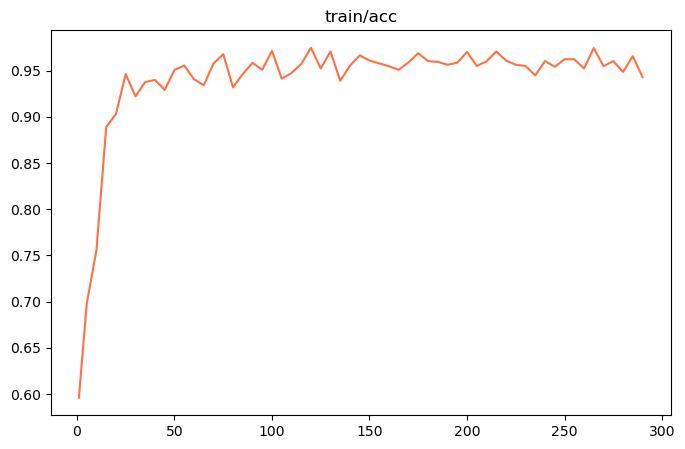

In [24]:
display(train_acc)

The training loss (**train/loss**) graph below shows a classic exponential decay pattern that is typical of successful model training. 

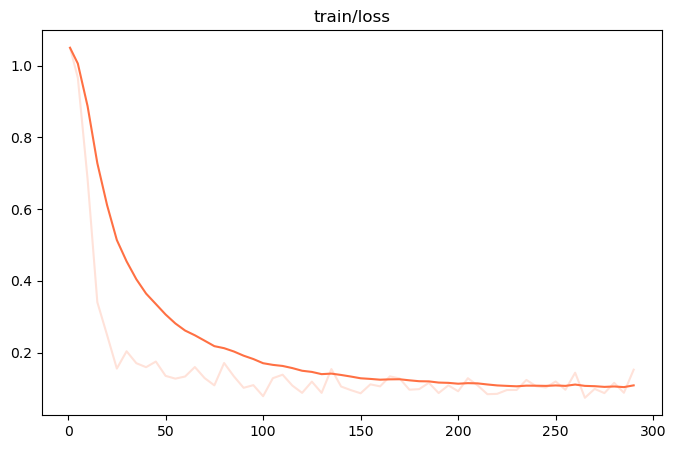

In [25]:
display(train_loss)

Together the training accuracy and training loss indicate that:
* The model reaches a stable state without signs of overfitting.
* The smooth curves suggest the learning rate was well-chosen for this task.
* Improvements after the 200th epoch are minimal and early stopping would make sense.

#### Accuracy and loss on Validation Dataset

The evaluation metrics show the performance of the model on the validation dataset. 

The validation ensures that the model does not just memorize the training data but actually learns something about the task from the data.

In [26]:
eval_acc = Image(filename='evaluation/qwen2-vl-2b-instruct/large/v0-20241120-161510/images/eval_acc.png') 
eval_loss = Image(filename='evaluation/qwen2-vl-2b-instruct/large/v0-20241120-161510/images/eval_loss.png') 

Below are the graphs for the evaluation accuracy (**eval/acc**) and evaluation loss (**eval/loss**).
Both evaluation metrics show consistent improvement without erratic behavior. This gradual improvement suggests good generalization to unseen real-world data.

The evaluation accuracy demonstrates consistent improvement, starting at 96% around epoch 50 and gradually climbing to approximately 97% by epoch 300, with a slight peak around epoch 200. When compared to the training metrics, the relatively small gap between training and evaluation performance (training accuracy ~95% vs evaluation accuracy ~97%) suggests the model is not overfitting. 

Overfitting means the model would only learn the training data and not generalize well. In the metrics this would show if the training metrics keep improving while the evaluation metrics worsen or plateau.

The evaluation loss shows a steady decrease from 0.125 to 0.095 over 300 epochs, with a notably smooth descent curve that indicates stable learning on unseen data. 


The relatively high accuracy and low loss values suggest this is a well-performing model on its intended multiple choice question answering task.

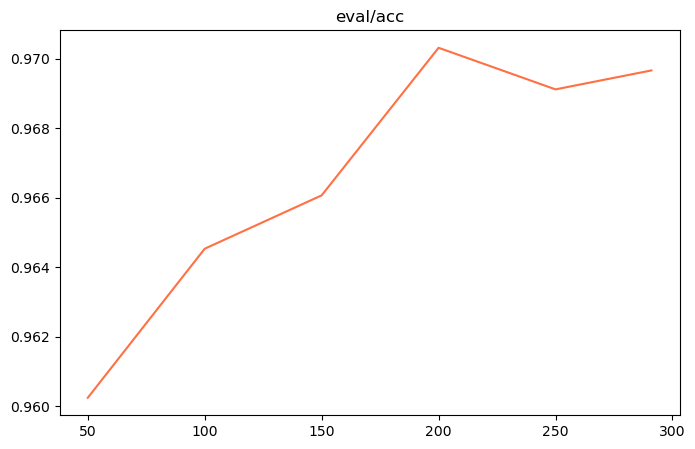

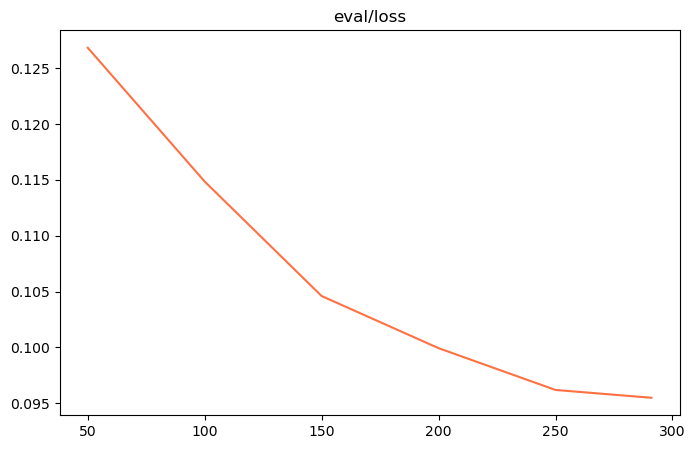

In [27]:
display(eval_acc)
display(eval_loss)

### Real-World Performance

In addition to the training and evaluation metrics we have also run inference on an additional test dataset that has not been used during training.


Large Language Models are challenging to evaluate due to their dynamic output generation, compared to simple classification tasks. The evaluation approach depends on the specific task and data, requiring data and task specific quantitative metrics and/or qualitative assessment methods for generated text, where multiple valid outputs may exist.

Our dataset specifically is multiple choice questions on a video. In this case we have a correct multiple choice answer and can use that as a quantitative metric.

Below you can see the accuracy (percentage of correct multiple choice answers) on the test dataset for the pre-trained model out of the box, the decent performance from fine-tuning on a small dataset, and the good performance when fine-tuning on a larger dataset for an extended time.

| Model | Instance | Fine-Tuning Duration | Dataset Size | Accuracy |
|----------|----------|----------|----------|----------|
| Qwen2 VL 2B (vanilla)    | no fine-tuning     | no fine-tuning     | N/A | 50% |
| Qwen2 VL 2B Fine-Tuned Small    | ml.g5.12xlarge     | 24 minutes     | 100 | 50% |
| Qwen2 VL 2B Fine-Tuned Large    | ml.g5.48xlarge     | 5 hours 39 minutes     | 4660 | 83% |

We load the inference results to look at some incorrect responses from the models:

In [28]:
qwen2_2b_responses = pd.read_json(
    "evaluation/qwen2-vl-2b-instruct/vanilla/outputs.jsonl",
    lines=True
)

In [29]:
qwen2_2b_fine_tuned_responses_small = pd.read_json(
    "evaluation/qwen2-vl-2b-instruct/small/outputs.jsonl",
    lines=True
)

In [30]:
qwen2_2b_fine_tuned_responses = pd.read_json(
    "evaluation/qwen2-vl-2b-instruct/large/outputs.jsonl",
    lines=True
)

Out of the box pre-trained Qwen2 VL 2B incorrect predictions:

In [31]:
# Show incorrect predictions
incorrect = qwen2_2b_responses[qwen2_2b_responses['label_choice'] != qwen2_2b_responses['response_choice']]
incorrect[['label', 'response', 'label_choice', 'response_choice']]

,label,response,label_choice,response_choice
2,A.,D,A,D
4,A.,C,A,C
5,C. Checkered.,The pattern on the floor in the hallway is che...,C,The pattern on the floor in the hallway is che...
7,A. A laptop and a plate.,The objects on the table are:\n\nA. A laptop\n...,A,The objects on the table are:\n\nA. A laptop\n...
8,B. Moderate.,The person in the video is seen walking around...,B,The person in the video is seen walking around...
9,D. A dark blue shirt and gray pants.,The person in the video is wearing a dark blue...,D,The person in the video is wearing a dark blue...


The incorrect predictions of fine-tuned Qwen2 VL 2B on a small dataset for 24 minutes are in the table below.

The accuracy didn't improve yet on the multiple-choice answering task compared to the out of the box pre-trained vanilla Qwen2 VL 2B. What we can already see is that the small fine-tuning has thought the model the expected output format of responding with the letter (for example "A.") from the available choices.

However, the answer options that the fine-tuned model selects are still 50% incorrect. The hypothesis is that to understand the videos better we will need to fine-tune on more data.

Fine-tuned model on small dataset incorrect predictions:

In [32]:
# Show incorrect predictions
incorrect = qwen2_2b_fine_tuned_responses_small[qwen2_2b_fine_tuned_responses_small['label_choice'] != qwen2_2b_fine_tuned_responses_small['response_choice']]
incorrect[['label', 'response', 'label_choice', 'response_choice']]

,label,response,label_choice,response_choice
1,C.,D.,C,D
2,A.,D.,A,D
4,A.,C.,A,C
5,C. Checkered.,D. Striped,C,D
7,A. A laptop and a plate.,B.,A,B
8,B. Moderate.,C. Very fast,B,C


Below are the results of fine-tuning Qwen2 VL 2B on a large dataset for longer. We can see that now the model has learned not just the response format but also understanding videos it has never seen and answering multiple-choice questions with great success.

From the 10 test questions it gets the following two wrong:

In [33]:
# Show incorrect predictions
incorrect = qwen2_2b_fine_tuned_responses[qwen2_2b_fine_tuned_responses['label_choice'] != qwen2_2b_fine_tuned_responses['response_choice']]
incorrect[['label', 'response', 'label_choice', 'response_choice']]

,label,response,label_choice,response_choice
1,C.,B.,C,B
7,A. A laptop and a plate.,B. A laptop and a framed picture.,A,B


Make sure to also include a qualitative human analysis of sample or failure cases, to ensure that the metric is aligning with your task specific expectations.